C:\Users\Cody\Documents\Python Scripts\osrs ge project\osrs-ge\osrs_GE.py:220: SyntaxWarning: invalid escape sequence '\W'
  id,interval = re.split("\W+|_",f)[-3:-1]


File read successfully for Master Files/items/master_file_11284_24h.csv


C:\Users\Cody\Documents\Python Scripts\osrs ge project\osrs-ge\osrs_GE.py:220: SyntaxWarning: invalid escape sequence '\W'
  id,interval = re.split("\W+|_",f)[-3:-1]


NameError: name 'plt' is not defined

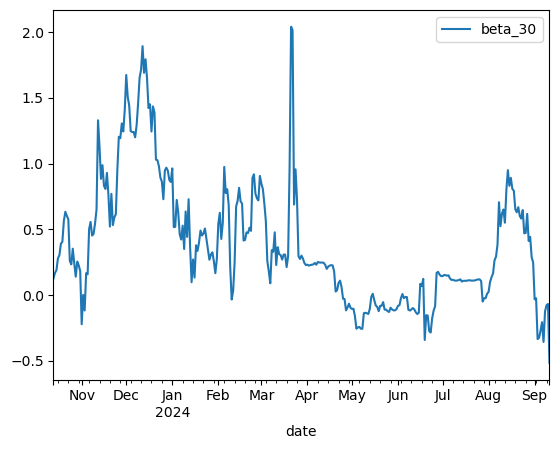

In [2]:
import os

import requests
import json

import pandas as pd
import numpy as np

from datetime import datetime
from datetime import timedelta

import webbrowser

import matplotlib.pyplot as plt
import seaborn as sns

from osrs_GE import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)

---

In [ ]:
# find a way to deal with dates being read in without the H M S

# /Users/codycao/Documents/Data projects/OSRS GE/osrs_GE.py:201: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
#  df['date'] = pd.to_datetime(df['date'])

df = read_item_master_file(4151,'24h')
df.index = pd.DatetimeIndex(df.index.values,freq=df.index.inferred_freq)
df = compute_VWAP(df)
df['simpRet'] = (df['VWAP']/df['VWAP'].shift(1)) - 1
df['logRet'] = np.log(df['VWAP']/df['VWAP'].shift(1))
df.head()

In [9]:
# create train test split
df = df.dropna()
train_idx = int(.7*df.index.shape[0])
train_dt = df.index[train_idx]
df_tr = df[df.index < train_dt]
df_te = df[df.index >= train_dt]

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

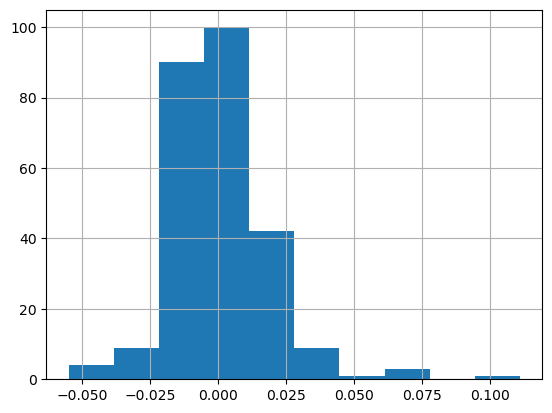

In [20]:
df_tr['simpRet'].hist()
plt.show()

In [22]:
df_tr['simpRet'].summary()

AttributeError: 'Series' object has no attribute 'summary'

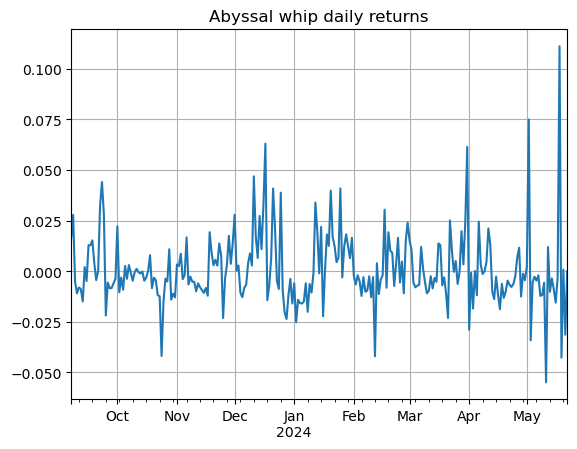

In [19]:
df_tr['simpRet'].plot()
plt.title('Abyssal whip daily returns')
plt.grid()
plt.show()

In [11]:
df_tr.head()

,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP,simpRet,logRet
2023-09-07,1694044800,1476230,1462323,1920,1897,1469318.400,0.017,0.016
2023-09-08,1694131200,1518417,1503441,1841,2260,1510163.950,0.028,0.027
2023-09-09,1694217600,1511792,1494355,2185,2647,1502239.902,-0.005,-0.005
2023-09-10,1694304000,1494277,1476987,2429,2328,1485815.550,-0.011,-0.011
2023-09-11,1694390400,1481644,1466097,2192,2184,1473884.711,-0.008,-0.008


In [13]:
adf_test = adfuller(df_tr['simpRet'])
print('t-stat:{:.3f}'.format(adf_test[0]))
print('p-value:{:.4f}'.format(adf_test[1]))
print('lags:{}'.format(adf_test[2]))

t-stat:-4.537
p-value:0.0002
lags:8


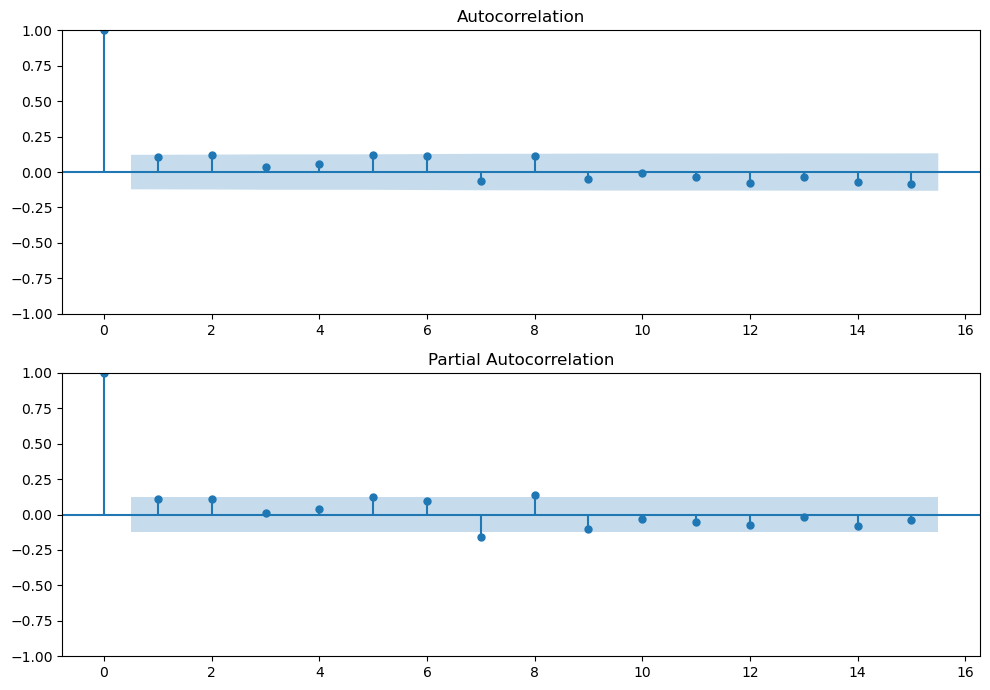

In [14]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
plot_acf(df_tr['simpRet'],lags=15, ax=ax[0])
plot_pacf(df_tr['simpRet'],lags=15, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

In [15]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_tr['simpRet'], order=(1,0,0))
model_fit = model.fit()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
def ARIMA_CV_SCORE(series,order = (1,0,0),start_point = 10):
    errors = []
    conv_issues = []
    preds = []
    for k in range(start_point,series.shape[0]-1):
        model = ARIMA(series.iloc[:k],order=order)
        model_fit = model.fit(method_kwargs={'maxiter':100})
        pred = (model_fit.forecast()).values[0]
        
        errors.append(pred - series.iloc[k+1])
        preds.append(pred)
        #print(k)
    
    ret_df = pd.DataFrame(index = series.index[start_point:-1],data = {'Pred':preds,'Real':series.iloc[start_point:-1]})
    errors = np.array(errors)
    return {'mean_error':errors.mean(), 'errors':errors, 'abs_errors':abs(errors),'ret_df':ret_df}

In [17]:
avg_err, err, abs_err, tmp_df = ARIMA_CV_SCORE(df_tr['simpRet'],(1,0,0))

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

In [21]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

res_list = {}

for p in range(1,9):
    print('Computing for AR({})'.format(p))
    res_list[p] = ARIMA_CV_SCORE(df_tr['simpRet'],(p,0,0))

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive para

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib

In [26]:
from pmdarima.arima import auto_arima
auto_res = auto_arima(df_tr['simpRet'],seasonal=False,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1350.757, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1350.784, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1351.940, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1351.350, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1353.150, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1351.206, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1351.254, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1354.088, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1351.886, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-1352.827, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1351.842, Time=0.06 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.229 seconds


In [23]:
[res_list[x]['abs_errors'].mean() for x in res_list]

[0.012542105395870765,
 0.012652231272026457,
 0.01274370184273145,
 0.012827338760228436,
 0.01281166791267347,
 0.01274647860044701,
 0.012859765110676762,
 0.013159733109636525]

In [24]:
[np.sqrt(np.sum(res_list[x]['errors']**2)) for x in res_list]

[0.29147552719019626,
 0.2927487187828728,
 0.29407187867759316,
 0.29633898411916704,
 0.2963460043319126,
 0.2971366704674348,
 0.30153410671207265,
 0.3071238463268444]

In [206]:
model = ARIMA(df_whip_tr['simpRet'],order = (1,0,0))
model_fit = model.fit(method_kwargs={'maxiter':100})

In [208]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                simpRet   No. Observations:                  243
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 665.114
Date:                Thu, 05 Sep 2024   AIC                          -1324.228
Time:                        16:58:40   BIC                          -1313.749
Sample:                    09-05-2023   HQIC                         -1320.007
                         - 05-04-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.721      0.471      -0.002       0.004
ar.L1          0.2160      0.045      4.756      0.000       0.127       0.305
sigma2         0.0002   1.55e-05     15.841      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               140.88
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

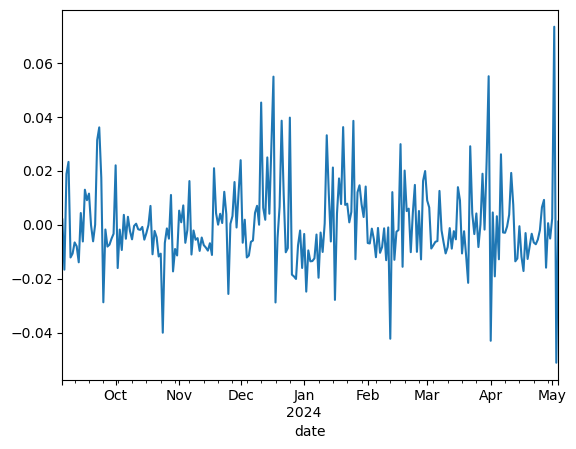

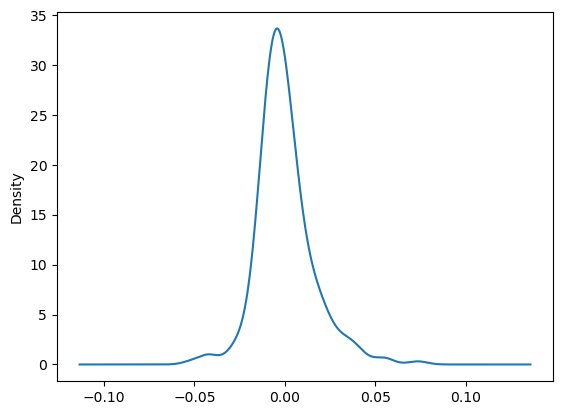

count   243.00000
mean     -0.00000
std       0.01570
min      -0.05121
25%      -0.00873
50%      -0.00203
75%       0.00636
max       0.07352
dtype: float64

In [214]:
#pd.reset_option('display.float_format')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

residuals = model_fit.resid
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

residuals.describe()

In [49]:
df_whip_te = df_test.dropna().loc[4151]
df_whip_te.head()

,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,avgWPrice,ttlVol,ttlNotional,logRet,simpRet
date,,,,,,,,,,
2024-05-05,1714867200,1875130,1856774.0,2903,2909,1.865943e+06,5812,1.084486e+10,-0.002736,-0.002733
2024-05-06,1714953600,1865004,1849538.0,2314,2312,1.857274e+06,4626,8.591751e+09,-0.004656,-0.004645
2024-05-07,1715040000,1862625,1844815.0,1947,2047,1.853497e+06,3994,7.402867e+09,-0.002036,-0.002034
2024-05-08,1715126400,1840624,1820968.0,2155,2112,1.830895e+06,4267,7.812429e+09,-0.012269,-0.012194
2024-05-09,1715212800,1820091,1797803.0,2219,2079,1.809310e+06,4298,7.776414e+09,-0.011859,-0.011789


In [113]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  363
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 957.590
Date:                Thu, 05 Sep 2024   AIC                          -1907.179
Time:                        14:11:53   BIC                          -1891.601
Sample:                             0   HQIC                         -1900.987
                                - 363                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.766e-06      0.001     -0.006      0.995      -0.003       0.003
ar.L1          0.0722      0.033      2.210      0.027       0.008       0.136
ar.L2          0.1116      0.069      1.612      0.107      -0.024       0.247
sigma2         0.0003    1.1e-05     27.099      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1873.12
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                             1.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

Test RMSE: 0.02082


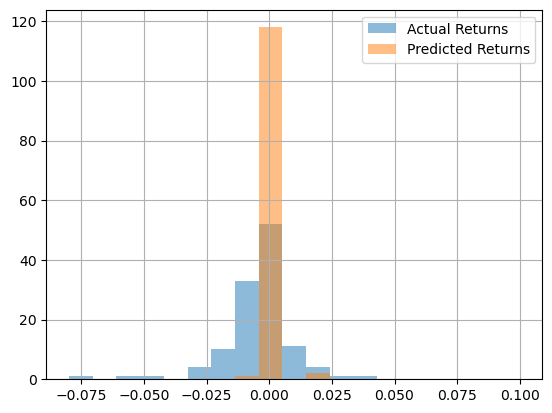

In [115]:
from sklearn.metrics import mean_squared_error
from math import sqrt

history = pd.DataFrame(df_tr['simpRet'].dropna())

predictions1 = []

AR_betas = pd.DataFrame()


for i in range(df_te.shape[0]):
    model = ARIMA(history['simpRet'].values,order=(1,0,0))
    model_fit=model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions1.append(yhat)
    obs = df_whip_te['simpRet'].iloc[i]
    history.loc[df_whip_te.index[i],'simpRet'] = obs
    AR_betas.loc[df_whip_te.index[i],'AR1_beta'] = model_fit.params[1]

    #print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(df_whip_te['simpRet'].values,predictions1))
print('Test RMSE: %.5f' % rmse)

bins = np.linspace(-.08,.10,20)
df_whip_te['simpRet'].hist(bins=bins,alpha=0.5,label='Actual Returns')
plt.hist(predictions1,bins,alpha=0.5,label='Predicted Returns')
plt.legend(loc='upper right')
plt.show()

In [51]:
(abs(np.array(predictions))>.01).sum()

3

C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Cody\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

Test RMSE: 0.02066


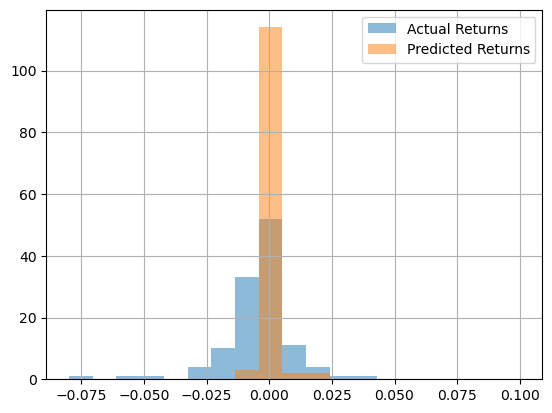

In [119]:
history = pd.DataFrame(df_train.loc[4151]['simpRet'].dropna())

predictions2 = []

for i in range(df_whip_te.shape[0]):
    model = ARIMA(history['simpRet'].values,order=(2,0,0))
    model_fit=model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions2.append(yhat)
    obs = df_whip_te['simpRet'].iloc[i]
    history.loc[df_whip_te.index[i],'simpRet'] = obs
    AR_betas.loc[df_whip_te.index[i],'AR2_beta1'] = model_fit.params[1]
    AR_betas.loc[df_whip_te.index[i],'AR2_beta2'] = model_fit.params[2]
    #print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(df_whip_te['simpRet'].values,predictions2))
print('Test RMSE: %.5f' % rmse)

bins = np.linspace(-.08,.10,20)
df_whip_te['simpRet'].hist(bins=bins,alpha=0.5,label='Actual Returns')
plt.hist(predictions2,bins,alpha=0.5,label='Predicted Returns')
plt.legend(loc='upper right')
plt.show()

In [53]:
print((abs(np.array(df_whip_te['simpRet']))>.01).sum())
print((abs(np.array(predictions1))>.01).sum())
print((abs(np.array(predictions2))>.01).sum())

42
3
3


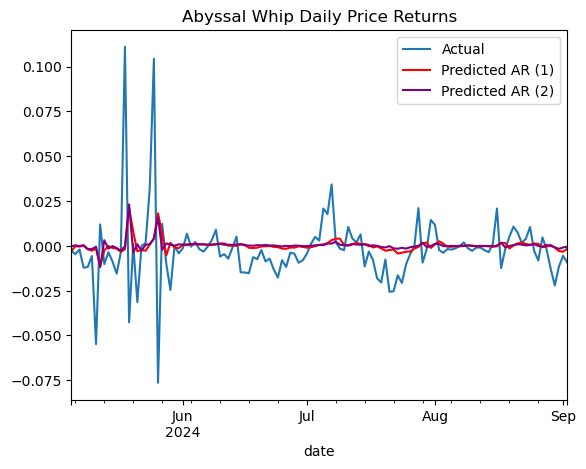

In [54]:
df_whip_te['simpRet'].plot(label='Actual')
plt.plot(df_whip_te.index,predictions2,color='red',label='Predicted AR (2)')
plt.plot(df_whip_te.index,predictions1,color='purple',label='Predicted AR (1)')
plt.legend()
plt.title("Abyssal Whip Daily Price Returns")
plt.show()

------

## AR model but optimizing on a different loss function

- In order to develop a reasonable investing strategy, we likely need a better loss function than just RMSE or MAE
- Sign matters more than just squared distance
    - what's worse than buying when you shouldn't have? buying when you should've sold (and vice versa)
- https://stackoverflow.com/questions/50711530/what-would-be-a-good-loss-function-to-penalize-the-magnitude-and-sign-difference

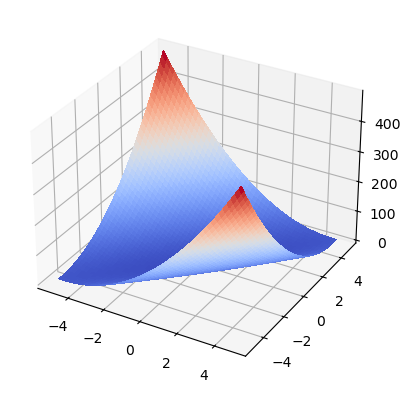

In [58]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def elliptic_paraboloid_loss(x, y, c_diff_sign=4, c_same_sign=0.1):
    # Compute a rotated elliptic parabaloid.
    t = np.pi / 4
    x_rot = (x * np.cos(t)) + (y * np.sin(t))
    y_rot = (x * -np.sin(t)) + (y * np.cos(t))
    z = ((x_rot**2) / c_diff_sign) + ((y_rot**2) / c_same_sign) 

    return(z)

def elliptic_paraboloid_loss_obj(B_vec, x_mat, y_obs,c_diff_sign = 8,c_same_sign = 0.001):
    # x_mat is nxp
    # B_mat is px1
    # y_obs is nx1
    n = x_mat.shape[0]
    p = x_mat.shape[1]

    B_vec = B_vec.reshape(p,1)
    y_obs = y_obs.reshape(n,1)

    return elliptic_paraboloid_loss(np.matmul(x_mat,B_vec),y_obs,c_diff_sign,c_same_sign).sum()

a = np.arange(-5, 5, 0.1)
b = np.arange(-5, 5, 0.1)

loss_map = np.zeros((len(a), len(b)))

for i, a_i in enumerate(a):
    for j, b_j in enumerate(b):
        loss_map[i, j] = elliptic_paraboloid_loss(a_i, b_j)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(a, b)
surf = ax.plot_surface(X, Y, loss_map, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

In [59]:
def create_lagged_df(series,lags):
    res = pd.DataFrame(series)
    col_name = res.columns[0]
    for k in range(1,lags+1):
        res[col_name + str(k)] = res[col_name].shift(k)
    return res

### Experimenting with AR(1)

Training data shape (242, 1)
Observation data shape (242,)
Beta vector shape (1,)
Minimization Complete
Beta1 = 0.2199
Elliptic Paraboloid Loss 0.0012734737510502214


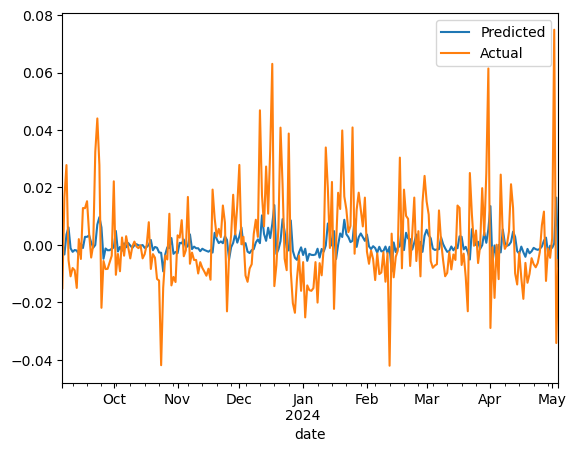

In [153]:
# Constructing the X matrix
X_tr = pd.DataFrame(df_whip_tr['simpRet'])

from scipy.optimize import minimize

# simpRet is our Y
# simpRet1 and simpRet 2 are our X

X_tr['simpRet1'] = X_tr['simpRet'].shift(1)

# get rid of the NaN's for experimenting purposes
X_tr = X_tr.dropna()

X_mat = X_tr[['simpRet1']].values
Y_vec = X_tr['simpRet'].values
B_init = np.ones(X_mat.shape[1])

print('Training data shape',X_mat.shape)
print('Observation data shape',Y_vec.shape)
print('Beta vector shape',B_init.shape)

res = minimize(elliptic_paraboloid_loss_obj,B_init,method='nelder-mead',args=(X_mat,Y_vec))

print("Minimization Complete")
print('Beta1 = %.4f' % (res.x[0]))

print('Elliptic Paraboloid Loss', elliptic_paraboloid_loss(np.matmul(X_mat,res.x),Y_vec).mean())

pd.DataFrame(data={'Predicted':np.matmul(X_mat,res.x),'Actual':Y_vec},index=X_tr.index).plot()
plt.show()

$$ \hat{R_t} = .2199 R_{t-1} $$

### Experimenting with AR(2)

Training data shape (241, 2)
Observation data shape (241,)
Beta vector shape (2,)
Minimization Complete
Beta1 = 0.2020, Beta2 = 0.0861
Elliptic Paraboloid Loss 0.0012651290587760416


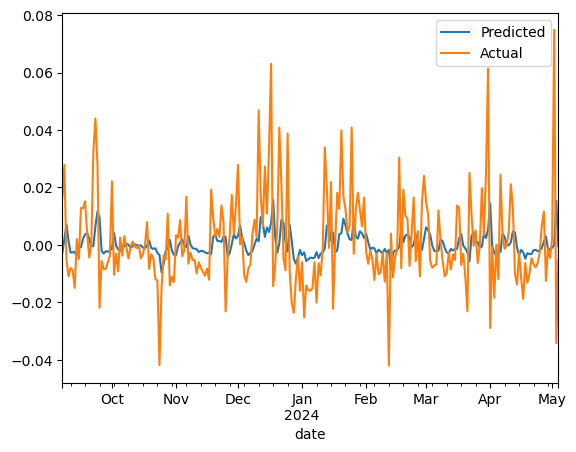

In [150]:
# Constructing the X matrix
X_tr = pd.DataFrame(df_whip_tr['simpRet'])

# simpRet is our Y
# simpRet1 and simpRet 2 are our X

X_tr['simpRet1'] = X_tr['simpRet'].shift(1)
X_tr['simpRet2'] = X_tr['simpRet'].shift(2)

# get rid of the NaN's for experimenting purposes
X_tr = X_tr.dropna()

X_mat = X_tr[['simpRet1','simpRet2']].values
Y_vec = X_tr['simpRet'].values
B_init = np.ones(X_mat.shape[1])

print('Training data shape', X_mat.shape)
print('Observation data shape', Y_vec.shape)
print('Beta vector shape', B_init.shape)

res = minimize(elliptic_paraboloid_loss_obj,B_init,method='nelder-mead',args=(X_mat,Y_vec))

print("Minimization Complete")
print('Beta1 = %.4f, Beta2 = %.4f' % (res.x[0], res.x[1]))

print('Elliptic Paraboloid Loss', elliptic_paraboloid_loss(np.matmul(X_mat,res.x),Y_vec).mean())

pd.DataFrame(data={'Predicted':np.matmul(X_mat,res.x),'Actual':Y_vec},index=X_tr.index).plot()
plt.show()

$$ \hat{R}_t = 0.2020*R_{t-1} + 0.0861 *R_{t-2} $$

### Experimenting with walk-forward

In [70]:
df_whip = df.loc[4151]

df_whip['simpRet'][dt_split+timedelta(days=1):]

date
2024-05-06   -0.005
2024-05-07   -0.002
2024-05-08   -0.012
2024-05-09   -0.012
2024-05-10   -0.006
              ...  
2024-08-29   -0.013
2024-08-30   -0.022
2024-08-31   -0.011
2024-09-01   -0.006
2024-09-02   -0.009
Freq: D, Name: simpRet, Length: 120, dtype: float64

In [133]:
pd.options.mode.chained_assignment = None  # default='warn'
predictions = pd.DataFrame(columns=['pred_AR1','pred_AR2','obs'])

X = df_whip[['simpRet']]
X_tr1 = create_lagged_df(X,1).dropna()
X_tr2 = create_lagged_df(X,2).dropna()

for date in df_whip_te.index:
    tr_date = date-timedelta(days=1)
    
    X_mat1 = X_tr1[:tr_date].drop(labels='simpRet',axis=1).values
    Y_vec1 = X_tr1['simpRet'][:tr_date].values
    
    X_mat2 = X_tr2[:tr_date].drop(labels='simpRet',axis=1).values
    Y_vec2 = X_tr2['simpRet'][:tr_date].values
    
    res1 = minimize(elliptic_paraboloid_loss_obj,[1]*1,method='nelder-mead',args=(X_mat1,Y_vec1))
    res2 = minimize(elliptic_paraboloid_loss_obj,[1]*2,method='nelder-mead',args=(X_mat2,Y_vec2))

    AR_betas.loc[date,'AR1e_beta'] = res1.x[0]
    AR_betas.loc[date,'AR2e_beta1'] = res2.x[0]
    AR_betas.loc[date,'AR2e_beta2'] = res2.x[1]
    
    x_vec_test1 = X_tr1.loc[date].drop('simpRet')
    x_vec_test2 = X_tr2.loc[date].drop('simpRet')
    y = X_tr1.loc[date]['simpRet']

    predictions.loc[date,'pred_AR1'] = np.matmul(res1.x,x_vec_test1)
    predictions.loc[date,'pred_AR2'] = np.matmul(res2.x,x_vec_test2)
    predictions.loc[date,'obs'] = y

In [135]:
AR_betas

,AR1_beta,AR2_beta1,AR2_beta2,AR1e_beta,AR2e_beta1,AR2e_beta2
2024-05-05,0.216,0.198,0.082,0.220,0.202,0.086
2024-05-06,0.216,0.199,0.082,0.220,0.202,0.085
2024-05-07,0.217,0.199,0.083,0.220,0.202,0.086
2024-05-08,0.217,0.199,0.083,0.220,0.202,0.086
2024-05-09,0.217,0.199,0.084,0.221,0.202,0.087
...,...,...,...,...,...,...
2024-08-29,0.076,0.068,0.111,0.076,0.068,0.111
2024-08-30,0.076,0.068,0.110,0.076,0.068,0.110
2024-08-31,0.078,0.070,0.110,0.078,0.070,0.110
2024-09-01,0.080,0.072,0.111,0.080,0.072,0.111


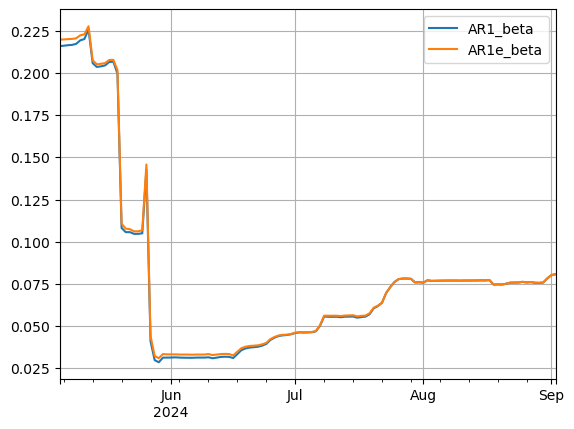

In [141]:
AR_betas[['AR1_beta','AR1e_beta']].plot()
plt.grid()
plt.show()

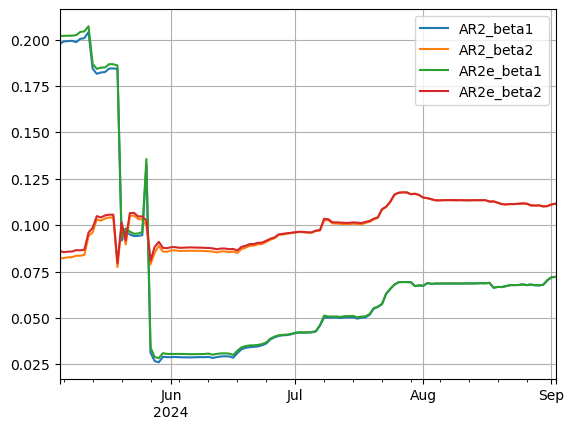

In [143]:
AR_betas[['AR2_beta1','AR2_beta2','AR2e_beta1','AR2e_beta2']].plot()
plt.grid()
plt.show()

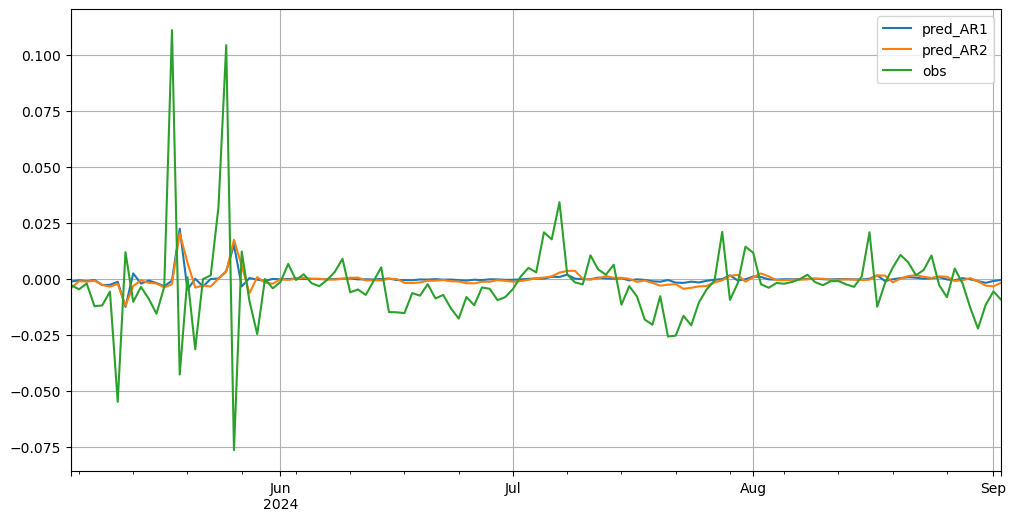

In [147]:
predictions.plot(figsize=(12,6))
plt.grid()
plt.show()

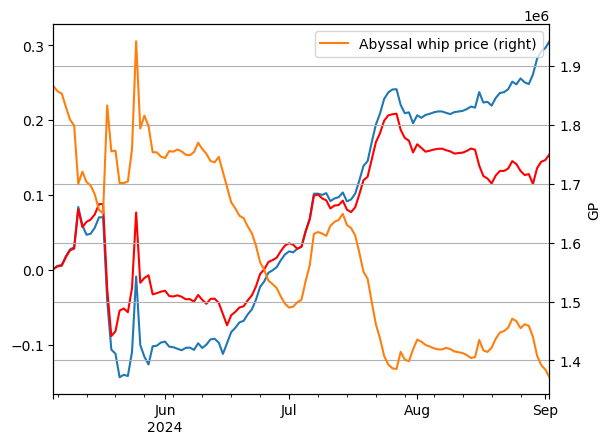

In [218]:
# Basic PnL in % returns for buy when signal is positive, sell when signal is negative, no filtering
# Assumes you place a trade every day

preds = predictions
preds = preds.join(df_whip[['avgWPrice']],how='left')

ax1 = ((preds['pred_AR1']*preds['obs']>0)*abs(preds['pred_AR1'] - preds['obs'])-
 (preds['pred_AR1']*preds['obs']<0)*abs(preds['pred_AR1']-preds['obs'])).cumsum().plot(label='AR1 PnL')

ax2 = ((preds['pred_AR2']*preds['obs']>0)*abs(preds['pred_AR2'] - preds['obs'])-
 (preds['pred_AR2']*preds['obs']<0)*abs(preds['pred_AR2']-preds['obs'])).cumsum().plot(label='AR2 PnL',color='red')

ax = preds['avgWPrice'].plot(secondary_y = True,label='Abyssal whip price')

ax.set_ylabel('GP')

plt.legend()
plt.grid()
plt.show()

In [145]:
'''
TODO:
    - Assume can only sell whip when you own one
    - Max inventory of one whip?
'''



'\nTODO:\n    - Assume can only sell whip when you own one\n    - Max inventory of one whip?\n'